In [ ]:
import numpy as np

## Defining Brownian Motion Function and Simulating Initial Haircuts

In [ ]:
from math import sqrt
from scipy.stats import norm

# Credit: https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html
def brownian(x0, n, dt, delta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.

    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.

    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples.
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

In [ ]:
T = 120 / 365
n = 2400
dt = T / n

treasury_drift = 0
treasury_vol = 1

# during 1: normal. immediately after 1: artificially inflate drift and vol of a risky asset. during 2: normal.
treasury_wiener1 = brownian(0, n, dt, 1)
treasury_wiener2 = brownian(0, n, dt, 1)

treasury_wiener = np.concatenate((treasury_wiener1, treasury_wiener2))

treasury_haircuts = np.exp(T * (treasury_drift - 0.5*(treasury_vol**2)) + treasury_vol * treasury_wiener)
treasury_haircuts[-1]

np.float64(1.2163797805369831)

In [ ]:
assets = 5
correlations = np.array([0.7, 0.7, 0.7, 0.7, 0.7])
volatilties = np.array([1.5, 1.5, 1.5, 1.5, 1.5])
drifts = np.array([1, 1, 1, 1, 1])
starting_points = np.array([5, 5, 5, 5, 5])

assets_wieners1 = np.array([treasury_wiener1 * correlations[i] + np.sqrt(1-(correlations[i])**2) * brownian(0, n, dt, 1) for i in range(assets)])
assets_haircuts1 = np.exp(np.array([np.log(starting_points[i]) + T * (drifts[i] - 0.5 * (volatilties[i]) ** 2) + volatilties[i] * assets_wieners1[i] for i in range(assets)]))

assets_haircuts1[:,-1]

array([4.41176614, 5.78709336, 8.37297857, 4.41909698, 3.37042845])

## Artificially Inflating Idiosyncratic Drift and Volatility for One Asset

In [ ]:
asset_index = 0 # index of asset to artificially inflate
drifts[asset_index] = 5
volatilties[asset_index] *= 1
starting_points = assets_haircuts1[:,-1]

assets_wieners2 = np.array([treasury_wiener2 * correlations[i] + np.sqrt(1-(correlations[i])**2) * brownian(0, n, dt, 1) for i in range(assets)])
assets_haircuts2 = np.exp(np.array([np.log(starting_points[i]) + T * (drifts[i] - 0.5 * (volatilties[i]) ** 2) + volatilties[i] * assets_wieners2[i] for i in range(assets)]))

assets_haircuts2[:,-1]

array([30.83492031,  9.87421336, 15.01035924,  4.72939944,  3.57699951])

The vector below now contains the complete simulated asset haircuts

In [ ]:
assets_haircuts = np.array([np.concatenate((assets_haircuts1[i], assets_haircuts2[i])) for i in range(assets)])

In [ ]:
assets_haircuts.shape

(5, 4800)

# Running the Spike Detection Algorithm

Compute **daily** Treasury and risky asset haircut rates from Monte Carlo quasi-continuous time-series

In [ ]:
day_window = int(T / (dt * 120))
daily_treasury_haircuts = np.array([np.mean(treasury_haircuts[i*day_window:(i+1)*day_window]) for i in range(int(treasury_haircuts.shape[0] / day_window))])
daily_assets_haircuts_arr = []
for i in range(assets):
  asset_haircuts = assets_haircuts[i]
  daily_asset_haircuts = np.array([asset_haircuts[(i+1)*day_window - 1] for i in range(int(asset_haircuts.shape[0] / day_window))])
  daily_assets_haircuts_arr.append(daily_asset_haircuts)

daily_assets_haircuts = np.array(daily_assets_haircuts_arr)


## Computing and Plotting Treasury Betas

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg_window = 7 # in days
lin_reg_treasury_haircuts = daily_treasury_haircuts.reshape(-1, 1)

treasury_betas = np.zeros((assets, daily_treasury_haircuts.shape[0]))

for i in range(assets):
  lin_reg_asset_haircuts = daily_assets_haircuts[i].reshape(-1, 1)
  for j in range(lin_reg_window, daily_treasury_haircuts.shape[0]):
    X = lin_reg_treasury_haircuts[j-lin_reg_window:j]
    Y = lin_reg_asset_haircuts[j-lin_reg_window:j]
    model = LinearRegression(fit_intercept=False).fit(X, Y)
    beta = model.coef_
    treasury_betas[i, j] = beta.item()

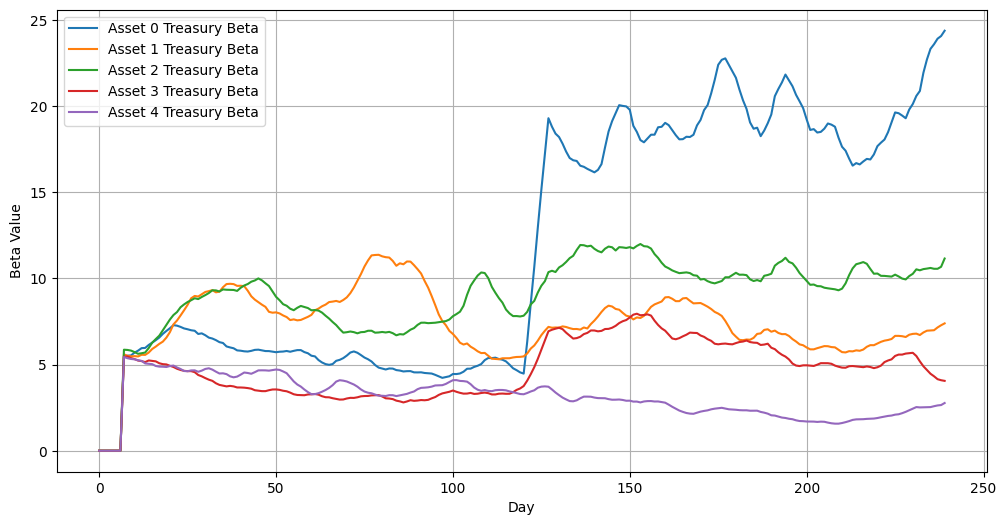

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(treasury_betas[0], label="Asset 0 Treasury Beta")
plt.plot(treasury_betas[1], label="Asset 1 Treasury Beta")
plt.plot(treasury_betas[2], label="Asset 2 Treasury Beta")
plt.plot(treasury_betas[3], label="Asset 3 Treasury Beta")
plt.plot(treasury_betas[4], label="Asset 4 Treasury Beta")

plt.xlabel('Day')
plt.ylabel('Beta Value')
plt.grid(True)
plt.legend()
plt.show()

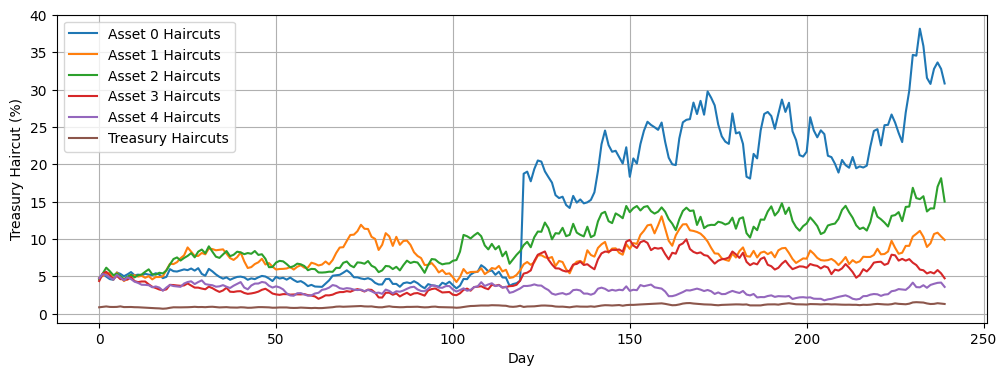

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(daily_assets_haircuts[0], label="Asset 0 Haircuts")
plt.plot(daily_assets_haircuts[1], label="Asset 1 Haircuts")
plt.plot(daily_assets_haircuts[2], label="Asset 2 Haircuts")
plt.plot(daily_assets_haircuts[3], label="Asset 3 Haircuts")
plt.plot(daily_assets_haircuts[4], label="Asset 4 Haircuts")
plt.plot(daily_treasury_haircuts, label="Treasury Haircuts")

plt.xlabel('Day')
plt.ylabel('Treasury Haircut (%)')
plt.grid(True)
plt.legend()
plt.show()

## Computing Beta Matrix

In [ ]:
beta_matrices = np.zeros((daily_treasury_haircuts.shape[0], assets, assets))

In [ ]:
daily_assets_haircuts.shape

(5, 240)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg_window = 7 # in days

for t in range(lin_reg_window-1, daily_assets_haircuts.shape[1]):
  for i in range(assets):
    asset_haircuts_i = daily_assets_haircuts[i, (t - lin_reg_window + 1):(t + 1)].reshape(-1,1)
    for j in range(assets):
      if j == i:
        beta_matrices[t,i,j] = 1
        continue
      asset_haircuts_j = daily_assets_haircuts[j, (t - lin_reg_window + 1):(t + 1)].reshape(-1, 1)
      model = LinearRegression(fit_intercept=False).fit(asset_haircuts_j, asset_haircuts_i)
      beta = model.coef_.item()
      beta_matrices[t,i,j] = beta

## Computing Exponential Beta Matrices Average

In [ ]:
beta_matrices_avg = np.zeros((daily_treasury_haircuts.shape[0], assets, assets))
exponential_weight = 0.05

In [ ]:
for t in range(lin_reg_window-1, beta_matrices_avg.shape[0]):
  if t == lin_reg_window-1:
    beta_matrix_avg = beta_matrices[t]
  else:
    prev_beta_matrix_avg = beta_matrices_avg[t - 1]
    beta_matrix_avg = exponential_weight * beta_matrices[t] + (1-exponential_weight) * prev_beta_matrix_avg
  beta_matrices_avg[t] = beta_matrix_avg

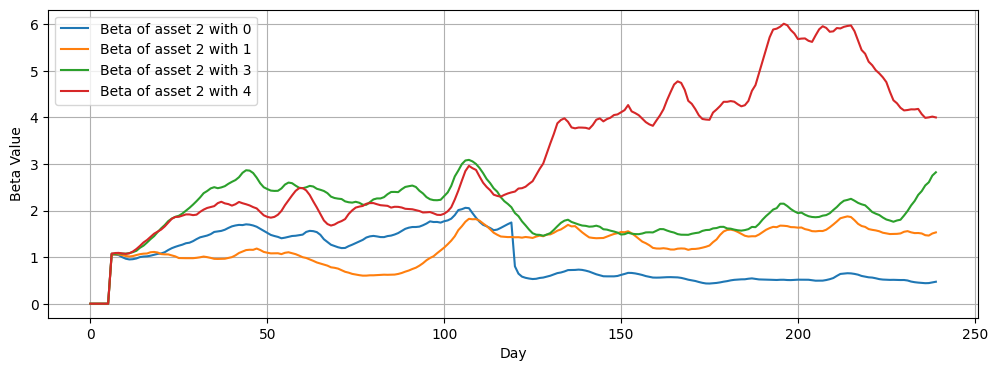

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(beta_matrices[:,2,0], label="Beta of asset 2 with 0")
plt.plot(beta_matrices[:,2,1], label="Beta of asset 2 with 1")
plt.plot(beta_matrices[:,2,3], label="Beta of asset 2 with 3")
plt.plot(beta_matrices[:,2,4], label="Beta of asset 2 with 4")

plt.xlabel('Day')
plt.ylabel('Beta Value')
plt.grid(True)
plt.legend()
plt.show()

## Beta Distance Calculation

In [ ]:
distances = np.zeros((assets, daily_assets_haircuts.shape[1]))

In [ ]:
for i in range(assets):
  for t in range(daily_assets_haircuts.shape[1]):
    if t >= lin_reg_window:
      distance = (1 / (assets - 1)) * np.linalg.norm(beta_matrices[t, i] - beta_matrices_avg[t-1, i])
      distances[i,t] = distance

In [ ]:
distances[0, 123]

np.float64(0.7090944575659727)

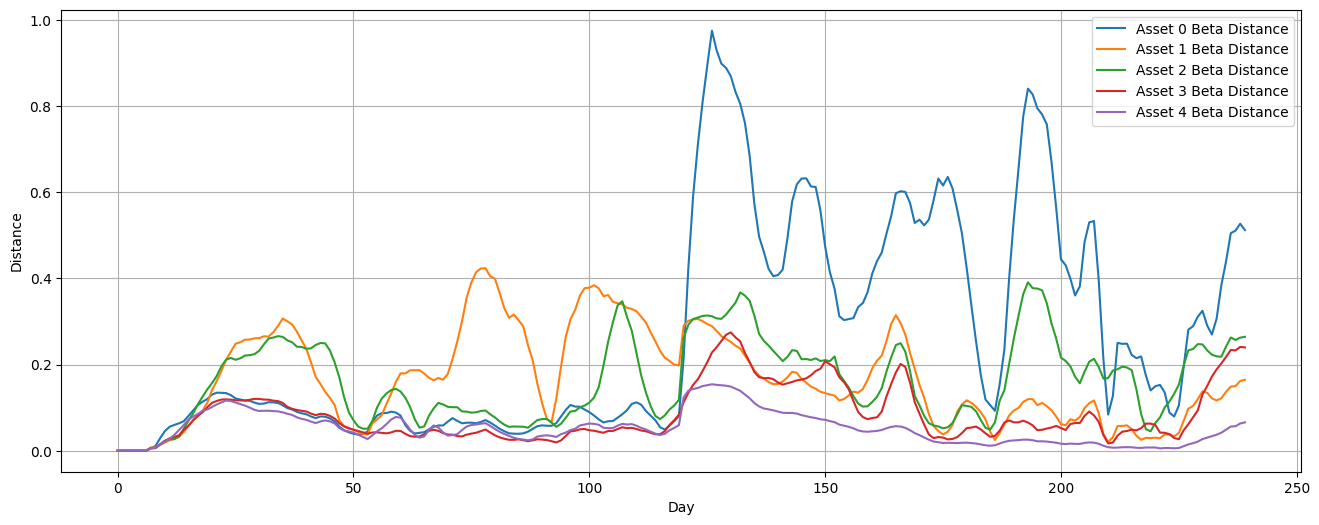

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(distances[0], label="Asset 0 Beta Distance")
plt.plot(distances[1], label="Asset 1 Beta Distance")
plt.plot(distances[2], label="Asset 2 Beta Distance")
plt.plot(distances[3], label="Asset 3 Beta Distance")
plt.plot(distances[4], label="Asset 4 Beta Distance")

plt.xlabel('Day')
plt.ylabel('Distance')
plt.grid(True)
plt.legend()
plt.show()

## Spike Detection

In [110]:
import pandas as pd

z_score_window = 10
spikes = 0

distances_spikes = np.zeros((assets, distances.shape[1]))

for i in range(assets):
  for t in range(distances.shape[1]-1, -1, -1):
    if t - lin_reg_window < lin_reg_window:
      continue

    distances_i = distances[i]
    pd_distances_i = pd.Series(distances_i)
    mean = pd_distances_i[lin_reg_window:].ewm(span=7, adjust=False).mean()[t-lin_reg_window]
    stddev = pd_distances_i[lin_reg_window:].ewm(span=7, adjust=False).std()[t-lin_reg_window]

    # avg_stddev = 0

    # for k in range(assets):
    #   distances_k = distances[k]
    #   pd_distances_k = pd.Series(distances_k)
    #   stddev = pd_distances_k[lin_reg_window:].ewm(span=2, adjust=False).std()[t-lin_reg_window]
    #   avg_stddev += stddev / assets

    if distances[i, t] > mean + 3 * stddev:
      distances_spikes[i, t] = 1

In [111]:
import pandas as pd

z_score_window = 10
spikes = 0

for i in range(assets):
  for t in range(daily_treasury_haircuts.shape[0]-1, -1, -1):
    if t - lin_reg_window < lin_reg_window:
      continue

    treasury_betas_i = treasury_betas[i]
    pd_treasury_betas_i = pd.Series(treasury_betas_i)
    mean = pd_treasury_betas_i[lin_reg_window:].ewm(span=2, adjust=False).mean()[t-lin_reg_window]
    stddev = pd_treasury_betas_i[lin_reg_window:].ewm(span=2, adjust=False).std()[t-lin_reg_window]
    # avg_stddev = 0

    # for k in range(assets):
    #   treasury_betas_k = treasury_betas[k]
    #   pd_treasury_betas_k = pd.Series(treasury_betas_k)
    #   stddev = pd_treasury_betas_k[lin_reg_window:].ewm(span=2, adjust=False).std()[t-lin_reg_window]
    #   avg_stddev += stddev / assets


    if treasury_betas[i, t] > mean + 3 * stddev and distances_spikes[i, t] == 1:
      print(f"Spike: asset {i} at time {t}. Distance: {distances[i, t]}")
      spikes += 1

Spike: asset 0 at time 239. Distance: 0.5124067330097406
Spike: asset 0 at time 238. Distance: 0.5270916740669738
Spike: asset 0 at time 196. Distance: 0.7808201797140404
Spike: asset 0 at time 195. Distance: 0.795022300366479
Spike: asset 0 at time 194. Distance: 0.8272958612945726
Spike: asset 0 at time 193. Distance: 0.8407158644163415
Spike: asset 0 at time 128. Distance: 0.8987524538506082
Spike: asset 0 at time 127. Distance: 0.9293839301781711
Spike: asset 0 at time 126. Distance: 0.9752725716276269
Spike: asset 0 at time 125. Distance: 0.8937004395234607
Spike: asset 0 at time 124. Distance: 0.8080091959138133
Spike: asset 0 at time 123. Distance: 0.7090944575659727
Spike: asset 0 at time 122. Distance: 0.5896414789986438
Spike: asset 0 at time 121. Distance: 0.42437315756497557
Spike: asset 0 at time 22. Distance: 0.1345186932411779
Spike: asset 0 at time 21. Distance: 0.13473389227529267
Spike: asset 0 at time 20. Distance: 0.13027123313196184
Spike: asset 0 at time 19. Dista

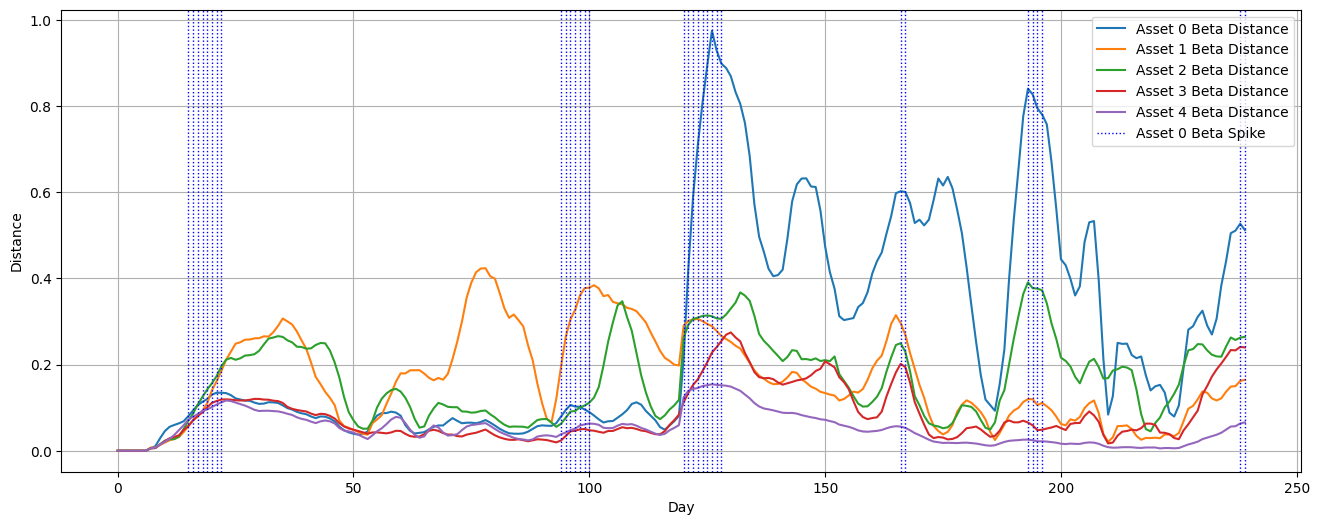

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(distances[0], label='Asset 0 Beta Distance')
plt.plot(distances[1], label='Asset 1 Beta Distance')
plt.plot(distances[2], label='Asset 2 Beta Distance')
plt.plot(distances[3], label='Asset 3 Beta Distance')
plt.plot(distances[4], label='Asset 4 Beta Distance')

spike_index = 0
for t in range(distances_spikes.shape[1]):
  if distances_spikes[spike_index, t] == 1:
    plt.axvline(x=t, color='blue', linestyle=':', linewidth=1, label=f'Asset {str(spike_index)} Beta Spike' if t == np.where(distances_spikes[spike_index] == 1)[0][0] else "") # Only label once

plt.xlabel('Day')
plt.ylabel('Distance')
plt.grid(True)
plt.legend()
plt.show()